<a href="https://colab.research.google.com/github/Mahadasim/Data_Practice/blob/master/UNET_OCT_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [49]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
import os
import PIL
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

from IPython.display import clear_output
from tqdm import tqdm_notebook, tnrange

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

**Import dataset**

Resizing binary images down will create a grayscale image


In [4]:
im_height, im_width = 256, 256

ids = next(os.walk("/content/drive/MyDrive/OCT_DATA/OCT Dataset/OCT Dataset/Image"))[2] # list of names all images in the given path
print("# of images =", len(ids))

X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32) # images
Y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32) # masks

# of images = 100


In [5]:
# tqdm is used to display the progress bar
DIR = "/content/drive/MyDrive/OCT_DATA/OCT Dataset/OCT Dataset/"

for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(DIR+"Image/"+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img(DIR+"Layer_Masks/"+id_))
    mask = resize(mask, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Grayscale -> Binary
    X[n] = x_img/255.0
    Ytemp = mask/255.0
    Y[n] = np.where(Ytemp > 0.5, 1, 0) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
# Check size for the images/masks
print(X.shape)
print(Y.shape)

(100, 256, 256, 1)
(100, 256, 256, 1)


In [7]:
# Split into train, test, validation set (60%, 20%, 20%)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

Text(0.5, 1.0, 'Mask')

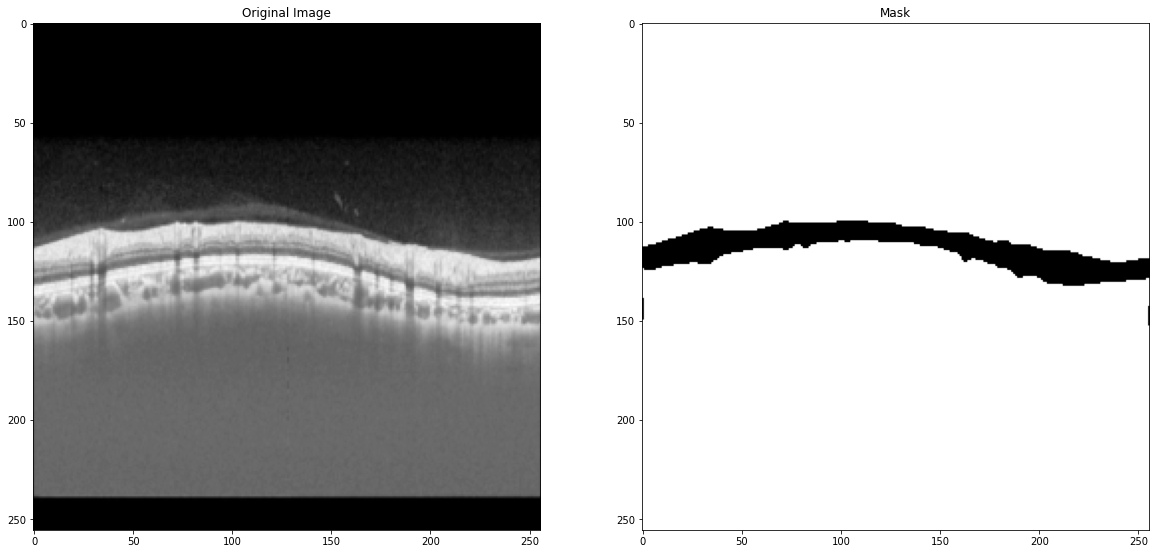

In [8]:
# Plot to show
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 20))
ax1.imshow(X_train[0].squeeze(), cmap='Greys_r') #squeeze is used when we want to remove single-dimensional entries from the shape of an array
ax1.set_title('Original Image')
ax2.imshow(Y_train[0].squeeze(), cmap='Greys_r')
ax2.set_title('Mask')


**CNN Model (Unet)**

First Construction of Layer is done, then model is defined where recursive feedback of weights are taken to extract the features

In [9]:
#Construction of CNN Layer
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x) #Normalize
    x = Activation('relu')(x) #Relu Activation
    
    return x

In [10]:
def get_unet(input_img, n_filters = 16, dropout = 0.2, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

**Keras Optimizer**

Adam Optimizer is used to enhance segmentation ability of CNN.

In [11]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

**CallBacks For Model**

In [13]:
# If no increase in accuracy (i.e min_lr = 0.00001). Therefore, the epoch will stop the procedure. 
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-OCT-BV.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

**Fit the Model**

In [ ]:
results = model.fit(X_train, Y_train, batch_size=3, epochs=100, callbacks=callbacks,\
                    validation_data=(X_val, Y_val))

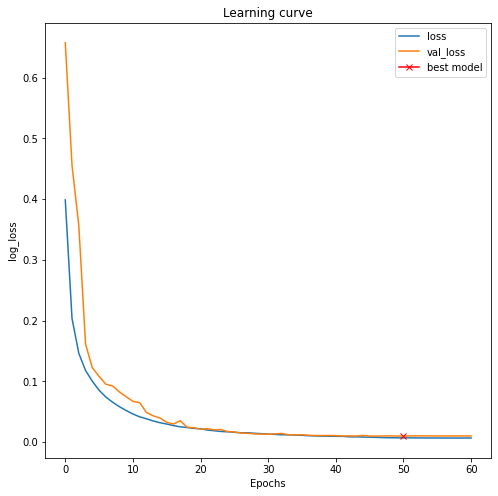

In [15]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


**LOAD THE WEIGHTS**



In [16]:
# load the best model
model.load_weights('model-OCT-BV.h5')

In [17]:
# Evaluate on test set
model.evaluate(X_test, Y_test, verbose=1)

1/1 [==============================] - 1s 1s/step - loss: 0.0101 - accuracy: 0.9969


[0.010070225223898888, 0.9968665838241577]

In [ ]:
# Predict on training and testing data
preds_train = model.predict(X_train, verbose=1)
print(preds_train)
preds_test = model.predict(X_test, verbose=1)
print(preds_test)

In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
print(preds_train)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
print(preds_test)

**Accuracy**

Dice_coefficient

Mean Euclidean Distance

In [51]:
def dice_coefficient(im1, im2):
  im1 = np.asarray(im1).astype(np.bool)
  im2 = np.asarray(im2).astype(np.bool)
  intersection = np.logical_and(im1, im2)
  return 2. * intersection.sum() / (im1.sum() + im2.sum())

my_predictions = model.predict(X_test)
y_pred = np.asarray(my_predictions*255)
y_pred = y_pred.astype(float)
y_true = Y_test
y_true = y_true.astype(float)
print(y_true.shape)
print(y_pred.shape)

dice_score = dice_coefficient(y_true, y_pred)
print("Dice Similarity: {}".format(dice_score))


#Mean Euclidean Distance
dist = np.zeros((im_height, im_width),dtype=np.float32)
y_preds = my_predictions.flatten()
y_true = y_true.flatten()

for i in range(len(y_preds)):
  dist = np.mean(abs(y_preds[i]-y_true[i]))

print("Mean Euclidean Distance: {}".format(dist))

(20, 256, 256, 1)
(20, 256, 256, 1)
Dice Similarity: 0.9754549099950833
Mean Euclidean Distance: 0.005273163318634033
